<a href="https://colab.research.google.com/github/linusloell/dataset-curation/blob/main/dataset_curation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 0. Setup

## 0.1 Install Dependencies

In [3]:
%%capture
!uv pip install fiftyone==1.7.0 torch==2.6.0 torchvision==0.21 numpy==2.0.2 open-clip-torch==3.2.0

In [5]:
# Plug-in to evaluate the performance of our classification models
!fiftyone plugins download \
    https://github.com/voxel51/fiftyone-plugins \
    --plugin-names @voxel51/evaluation
!fiftyone plugins download https://github.com/jacobmarks/clustering-plugin

  329.4Mb [5.9s elapsed, ? remaining, 66.2Mb/s]    
Copying plugin '@voxel51/evaluation' to '/home/linus/fiftyone/__plugins__/@voxel51/evaluation'
  162.8Kb [19.1ms elapsed, ? remaining, 8.3Mb/s] 
Copying plugin '@jacobmarks/clustering' to '/home/linus/fiftyone/__plugins__/@jacobmarks/clustering'


In [1]:
import os

# Set environment variables for reproducibility BEFORE importing torch
os.environ['PYTHONHASHSEED'] = '51'
os.environ['CUBLAS_WORKSPACE_CONFIG'] = ':4096:8'

from PIL import Image
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as Fun
import torchvision.transforms.v2 as transforms
import fiftyone as fo
import fiftyone.zoo as foz
import fiftyone.brain as fob
from torch.utils.data import Dataset, ConcatDataset
from fiftyone import ViewField as F
import fiftyone.utils.random as four
from tqdm import tqdm
from torch.optim import Adam
from pathlib import Path
import matplotlib.pyplot as plt
import gc
import albumentations as A
import cv2
import random
from typing import Optional, Dict, Tuple, Any
from huggingface_hub import notebook_login
import fiftyone.utils.huggingface as fouh

/home/linus/miniconda3/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 0.1 Load Data and set random seeds

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cuda


In [3]:
def set_seeds(seed=51):
    """
    Set seeds for complete reproducibility across all libraries and operations.

    Args:
        seed (int): Random seed value
    """
    # Set environment variables before other imports
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['CUBLAS_WORKSPACE_CONFIG'] = ':4096:8'

    # Python random module
    # random.seed(seed)

    # NumPy
    np.random.seed(seed)

    # PyTorch CPU
    torch.manual_seed(seed)

    # PyTorch GPU (all devices)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)  # For multi-GPU setups

        # CUDA deterministic operations
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

    # OpenCV
    #cv2.setRNGSeed(seed)

    # Albumentations (for data augmentation)
    #try:
        #A.seed_everything(seed)
    #except AttributeError:
        # Older versions of albumentations
    #    pass

    # PyTorch deterministic algorithms (may impact performance)
    try:
        torch.use_deterministic_algorithms(True)
    except RuntimeError:
        # Some operations don't have deterministic implementations
        print("Warning: Some operations may not be deterministic")

    print(f"All random seeds set to {seed} for reproducibility")



# Usage: Call this function at the beginning and before each training phase
set_seeds(51)

def create_deterministic_training_dataloader(dataset, batch_size, shuffle=True, **kwargs):
    """
    Create a DataLoader with deterministic behavior.

    Args:
        dataset: PyTorch Dataset instance
        batch_size: Batch size
        shuffle: Whether to shuffle data
        **kwargs: Additional DataLoader arguments

    Returns:
        Training DataLoader with reproducible behavior
    """
    # Use a generator with fixed seed for reproducible shuffling
    generator = torch.Generator()
    generator.manual_seed(51)

    return torch.utils.data.DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=shuffle,
        generator=generator if shuffle else None,
        **kwargs
    )

All random seeds set to 51 for reproducibility


In [20]:
train_val_dataset = foz.load_zoo_dataset("mnist",
                                         split='train',
                                         dataset_name="mnist-train-val",
                                         persistent=True)
test_dataset = foz.load_zoo_dataset("mnist",
                                    split='test',
                                    dataset_name="mnist-test",
                                    persistent=True)
train_val_dataset.compute_metadata()
test_dataset.compute_metadata()

Split 'train' already downloaded
Loading existing dataset 'mnist-train-val'. To reload from disk, either delete the existing dataset or provide a custom `dataset_name` to use
Split 'test' already downloaded
Loading existing dataset 'mnist-test'. To reload from disk, either delete the existing dataset or provide a custom `dataset_name` to use


In [21]:
# The images come with the 'train' tag and this must be deleted
# at the sample level.
train_val_dataset.untag_samples(["train", "validation"])

In [22]:
# delete existing datasets
if (fo.dataset_exists("mnist-training-set")):
    fo.delete_dataset("mnist-training-set")

if fo.dataset_exists("mnist-validation-set"):
    fo.delete_dataset("mnist-validation-set")

In [23]:
set_seeds(51)
# Create random 85%/15% split using tags
four.random_split(train_val_dataset,
                  {"train": 0.85, "validation": 0.15},
                  # The seed makes the split reproducible
                  seed=51)

# Verify the split by counting tags
tag_counts = train_val_dataset.count_sample_tags()
print("Tag counts after split:")
print(tag_counts)

# Separate validation and train FO datasets
train_dataset = train_val_dataset.match_tags("train").clone()
val_dataset = train_val_dataset.match_tags("validation").clone()

# Set names for FO datasets using the 'name' property
train_dataset.name = "mnist-training-set"
val_dataset.name = "mnist-validation-set"

# Define persistency
train_dataset.persistent = True
val_dataset.persistent = True

# Verify no overlap between train and validation
train_ids = set(train_dataset.values("id"))
val_ids = set(val_dataset.values("id"))
overlap = train_ids.intersection(val_ids)

All random seeds set to 51 for reproducibility
Tag counts after split:
{'validation': 9000, 'mistaken': 47, 'train': 51000, 'hard': 35}


In [24]:
dataset_classes = sorted(test_dataset.distinct("ground_truth.label"))
label_map = {string_label: index for index, string_label in enumerate(dataset_classes)}

In [25]:
session = fo.launch_app(train_dataset, auto=False)
print(session.url)

Session launched. Run `session.show()` to open the App in a cell output.
http://localhost:5151/


# 1. Training LeNet5

## 2.1 Defining the Model

### Model Architecure

In [44]:
class ModernLeNet5(nn.Module):
    """
    Modernized version of LeNet-5 with ReLU activations and max pooling.
    Often performs better on MNIST than the original version.
    """

    def __init__(self, num_classes=10):
        super(ModernLeNet5, self).__init__()

        self.conv1 = nn.Conv2d(1, 6, kernel_size=5)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
        self.conv3 = nn.Conv2d(16, 120, kernel_size=4)

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.fc1 = nn.Linear(120, 84)
        self.fc2 = nn.Linear(84, num_classes)

        self.dropout = nn.Dropout(0.5)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = self.relu(self.conv3(x))

        x = x.view(x.size(0), -1)
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)

        return x

### Dataset

In [36]:
class CustomTorchImageDataset(torch.utils.data.Dataset):
    def __init__(self, fiftyone_dataset, image_transforms=None, label_map=None):
        self.image_paths = fiftyone_dataset.values("filepath")
        self.str_labels = fiftyone_dataset.values("ground_truth.label")
        self.image_transforms = image_transforms
        self.label_map = label_map or {str(i): i for i in range(10)}

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert('L')
        if self.image_transforms:
            image = self.image_transforms(image)

        label_str = self.str_labels[idx]
        label_idx = self.label_map[label_str]

        return image, torch.tensor(label_idx, dtype=torch.long)

    def __len__(self):
        return len(self.image_paths)

In [13]:
dataset_classes = sorted(test_dataset.distinct("ground_truth.label"))
label_map = {string_label: index for index, string_label in enumerate(dataset_classes)}

In [32]:
def compute_stats_fiftyone(fiftyone_view):
    """
    Compute stats directly from FiftyOne using aggregations.
    Requires images to be loaded as arrays.
    """

    print("Computing image intensity statistics from FiftyOne view...")

    # Get all image filepaths
    filepaths = fiftyone_view.values("filepath")

    # Load all pixel values
    all_pixels = []

    for filepath in tqdm(filepaths):

        try:
            # Load image as grayscale array
            image = Image.open(filepath).convert('L')
            # Scale values to the range [0, 1]
            pixels = np.array(image, dtype=np.float32) / 255.0
            all_pixels.append(pixels.flatten())
        except Exception as e:
            print(f"Error loading {filepath}: {e}")
            continue

    # Concatenate all pixel values
    all_pixels = np.concatenate(all_pixels)

    # Compute statistics
    mean = np.mean(all_pixels)
    std = np.std(all_pixels)

    print(f"Computed from {len(filepaths)} images")
    print(f"Total pixels: {len(all_pixels):,}")

    return mean, std

mean_intensity, std_intensity = compute_stats_fiftyone(train_dataset)
f"TRAIN: Mean: {mean_intensity:.4f}, Std: {std_intensity:.4f}"
mean_intensity, std_intensity = compute_stats_fiftyone(val_dataset)
f"VAL: Mean: {mean_intensity:.4f}, Std: {std_intensity:.4f}"

Computing image intensity statistics from FiftyOne view...


100%|██████████| 51000/51000 [00:10<00:00, 4815.14it/s]


Computed from 51000 images
Total pixels: 39,984,000
Computing image intensity statistics from FiftyOne view...


100%|██████████| 9000/9000 [00:02<00:00, 4321.54it/s]

Computed from 9000 images
Total pixels: 7,056,000


'VAL: Mean: 0.1319, Std: 0.3075'

In [15]:
image_transforms = transforms.Compose([
    transforms.ToImage(),
    transforms.ToDtype(torch.float32, scale=True),
    transforms.Normalize((mean_intensity,), (std_intensity,))
])

In [16]:
torch_train_set = CustomTorchImageDataset(train_dataset,
                                          label_map=label_map,
                                          image_transforms=image_transforms)

In [17]:
torch_val_set = CustomTorchImageDataset(val_dataset,
                                     label_map=label_map,
                                     image_transforms=image_transforms)

### data loaders

In [18]:
# Define batch size (you can adjust this based on your GPU memory)
batch_size = 64
num_workers = os.cpu_count()  # Number of CPU cores

In [19]:
train_loader = create_deterministic_training_dataloader(
    torch_train_set,
    batch_size=64,
    shuffle=True,
    num_workers=num_workers,
    pin_memory=True
)

In [20]:
val_loader = torch.utils.data.DataLoader(
    torch_val_set,
    batch_size=batch_size,
    shuffle=False, # No need to shuffle validation data
    num_workers=num_workers,
    pin_memory=True
)

print("Train and validation DataLoaders created successfully.")
print(f"Train DataLoader has {len(train_loader)} batches.")
print(f"Validation DataLoader has {len(val_loader)} batches.")

Train and validation DataLoaders created successfully.
Train DataLoader has 797 batches.
Validation DataLoader has 141 batches.


### Loss-Function

In [21]:
ce_loss = nn.CrossEntropyLoss()

### define model and optimizer

In [22]:
model = ModernLeNet5().to(device)

# Define the optimizer (variant of stochastic gradient descent)
optimizer = Adam(model.parameters(),
                 lr=0.003, betas=(0.9, 0.999),
                 eps=1e-08, weight_decay=0)


### train and validate methodes

In [23]:
def train_epoch(model, train_loader):
  batch_losses = []
  model.train()
  for images, labels in tqdm(train_loader, desc="Training: "):
      #import pdb; pdb.set_trace()

      images = images.to(device)
      labels = labels.to(device)
      # Forward pass
      logits = model(images)
      loss_value = ce_loss(logits, labels)
      # Clear gradients from previous iteration (PyTorch accumulates by default)
      optimizer.zero_grad()
      # Computes the gradients with backpropagation
      loss_value.backward()
      # Updates the weights
      optimizer.step()

      batch_losses.append(loss_value.item())

  train_loss = np.mean(batch_losses)
  return train_loss


In [24]:
def val_epoch(model, val_loader):
  batch_losses = []
  model.eval()
  with torch.inference_mode():
    for images, labels in tqdm(val_loader, desc="Validation: "):
      images = images.to(device)
      labels = labels.to(device)
      # Forward pass
      logits = model(images)
      loss_value = ce_loss(logits, labels)
      batch_losses.append(loss_value.item())
  val_loss = np.mean(batch_losses)
  return val_loss

## 2.2 Training the Model

In [35]:
# Ensure reproducibility for the training process
set_seeds(51) # You can change this number to get different results

num_epochs = 10
train_losses = []
val_losses = []

best_val_loss = float('inf')
best_model = None

# Define the path to save the model within your hard-drive
path = Path(os.getcwd()) # Feel free to change the path

model_save_path = path / 'best_lenet.pth'

for epoch in range(num_epochs):
    train_loss = train_epoch(model, train_loader)
    val_loss = val_epoch(model, val_loader)
    train_losses.append(train_loss)
    val_losses.append(val_loss)


    print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f} - Val Loss: {val_loss:.4f}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model = model
        # Save the best model
        torch.save(best_model.state_dict(), model_save_path)
        print('Found and saved better weights for the model')

All random seeds set to 51 for reproducibility


Training:   0%|          | 0/797 [00:00<?, ?it/s]

Validation: 100%|██████████| 141/141 [00:01<00:00, 92.04it/s] 


Epoch 1/10 - Train Loss: 0.2188 - Val Loss: 0.0825
Found and saved better weights for the model


Validation: 100%|██████████| 141/141 [00:01<00:00, 108.58it/s]


Epoch 2/10 - Train Loss: 0.0801 - Val Loss: 0.0653
Found and saved better weights for the model


Validation: 100%|██████████| 141/141 [00:01<00:00, 104.58it/s]


Epoch 3/10 - Train Loss: 0.0633 - Val Loss: 0.0552
Found and saved better weights for the model


Validation: 100%|██████████| 141/141 [00:01<00:00, 104.16it/s]


Epoch 4/10 - Train Loss: 0.0503 - Val Loss: 0.0501
Found and saved better weights for the model


Validation: 100%|██████████| 141/141 [00:01<00:00, 107.32it/s]


Epoch 5/10 - Train Loss: 0.0455 - Val Loss: 0.0525


Validation: 100%|██████████| 141/141 [00:01<00:00, 108.06it/s]


Epoch 6/10 - Train Loss: 0.0442 - Val Loss: 0.0648


Validation: 100%|██████████| 141/141 [00:01<00:00, 98.17it/s] 


Epoch 7/10 - Train Loss: 0.0386 - Val Loss: 0.0596


Validation: 100%|██████████| 141/141 [00:01<00:00, 101.07it/s]


Epoch 8/10 - Train Loss: 0.0397 - Val Loss: 0.0530


Validation: 100%|██████████| 141/141 [00:01<00:00, 99.10it/s] 


Epoch 9/10 - Train Loss: 0.0311 - Val Loss: 0.0652


Validation: 100%|██████████| 141/141 [00:01<00:00, 103.32it/s]

Epoch 10/10 - Train Loss: 0.0373 - Val Loss: 0.0588


### visualize training process

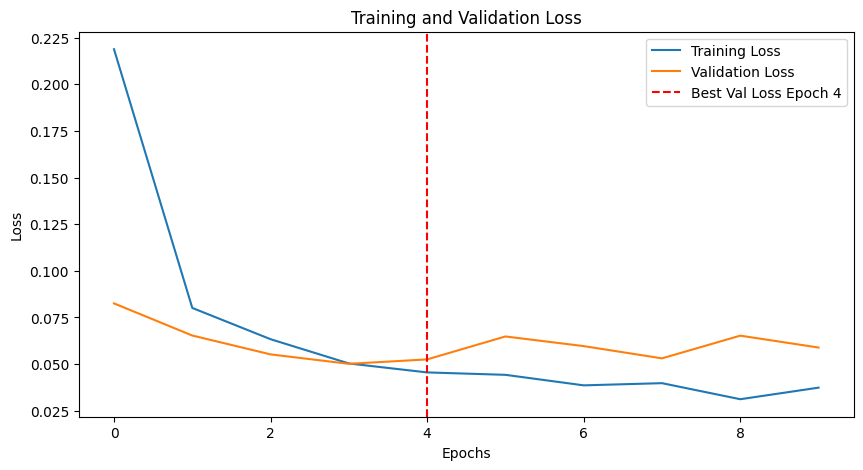

In [36]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

# Find the epoch with the best validation loss
best_epoch = np.argmin(val_losses) + 1 # Add 1 because epochs are 1-indexed

# Add a vertical red line at the epoch with the best validation loss
plt.axvline(x=best_epoch, color='red', linestyle='--', label=f'Best Val Loss Epoch {best_epoch}')
plt.legend()

plt.show()

### Load best version of model

In [25]:
# Define the path where the best model was saved
path = Path(os.getcwd())
model_save_path = path / 'best_lenet.pth'

# Instantiate a new model with the same architecture
# Make sure you use the same model class that was trained
loaded_model = ModernLeNet5()

# Load the saved state dictionary into the new model instance
# Make sure the model is on the correct device (CPU or GPU)
device = "cuda" if torch.cuda.is_available() else "cpu"
loaded_model.load_state_dict(torch.load(model_save_path, map_location=device))

# Move the model to the device
loaded_model = loaded_model.to(device)

# Set the model to evaluation mode
loaded_model.eval()

print(f"Model loaded successfully from {model_save_path}")
print(f"Model is on device: {next(loaded_model.parameters()).device}")

Model loaded successfully from /home/linus/HPI/cv-seminar/best_lenet.pth
Model is on device: cuda:0


In [25]:
import torch
# This uses the torch_train_set which is derived from train_dataset
train_inference_loader = torch.utils.data.DataLoader(
    torch_train_set,
    batch_size=batch_size,
    shuffle=False,    # CRITICAL: Must be False for ordered predictions
    num_workers=num_workers,
    pin_memory=True
)

# Set the loaded model to evaluation mode
loaded_model.eval()

# Lists to store predictions and logits for the training set
train_predictions = []
train_all_logits = []

# Run inference on the training set using the NON-SHUFFLED loader
print("Applying LeNet model to the train_dataset (using non-shuffled loader)...")
with torch.inference_mode(): # Disable gradient calculation
    # Use the new train_inference_loader
    for images, _ in tqdm(train_inference_loader, desc="Processing train batches for inference"):
        images = images.to(device)

        # Forward pass to get logits
        logits = loaded_model(images)
        train_all_logits.append(logits.cpu().numpy()) # Store logits

        # Get predicted class indices
        _, predicted = torch.max(logits.data, 1)
        train_predictions.extend(predicted.cpu().numpy()) # Store predictions

# Concatenate logits from all batches
train_all_logits = np.concatenate(train_all_logits, axis=0)

print("Inference on train_dataset complete.")
print(f"Shape of collected train logits: {train_all_logits.shape}")
print(f"Number of collected train predictions: {len(train_predictions)}")

# Store the predictions and logits back into the FiftyOne dataset as Classification objects
print("Storing predictions and logits as FiftyOne Classifications for train_dataset...")
for i, sample in enumerate(tqdm(train_dataset, desc="Storing train classifications")):
    predicted_idx = train_predictions[i]
    predicted_label = dataset_classes[predicted_idx] # Assuming dataset_classes is consistent
    sample_logits = train_all_logits[i]
    confidences = Fun.softmax(torch.tensor(sample_logits), dim=0).numpy()
    predicted_confidence = float(confidences[predicted_idx])
    classification = fo.Classification(
        label=predicted_label,
        confidence=predicted_confidence,
        logits=sample_logits.tolist()
    )
    sample["lenet_train_classification"] = classification
    sample.save()

print("Predictions and logits stored successfully as FiftyOne Classifications for train_dataset.")

Applying LeNet model to the train_dataset (using non-shuffled loader)...


Processing train batches for inference: 100%|██████████| 797/797 [00:07<00:00, 108.35it/s]


Inference on train_dataset complete.
Shape of collected train logits: (51000, 10)
Number of collected train predictions: 51000
Storing predictions and logits as FiftyOne Classifications for train_dataset...


Storing train classifications: 100%|██████████| 51000/51000 [01:47<00:00, 476.53it/s]

Predictions and logits stored successfully as FiftyOne Classifications for train_dataset.


In [26]:
# doing the same for the validation dataset
# This uses the torch_validation_set which is derived from validation_dataset
val_inference_loader = torch.utils.data.DataLoader(
    torch_val_set,
    batch_size=batch_size,
    shuffle=False,    # CRITICAL: Must be False for ordered predictions
    num_workers=num_workers,
    pin_memory=True
)

# Set the loaded model to evaluation mode
loaded_model.eval()

# Lists to store predictions and logits for the validation set
val_predictions = []
val_all_logits = []

# Run inference on the validation set using the NON-SHUFFLED loader
print("Applying LeNet model to the validation_dataset (using non-shuffled loader)...")
with torch.inference_mode(): # Disable gradient calculation
    # Use the new val_inference_loader
    for images, _ in tqdm(val_inference_loader, desc="Processing validation batches for inference"):
        images = images.to(device)

        # Forward pass to get logits
        logits = loaded_model(images)
        val_all_logits.append(logits.cpu().numpy()) # Store logits

        # Get predicted class indices
        _, predicted = torch.max(logits.data, 1)
        val_predictions.extend(predicted.cpu().numpy()) # Store predictions

# Concatenate logits from all batches
val_all_logits = np.concatenate(val_all_logits, axis=0)

print("Inference on validation_dataset complete.")
print(f"Shape of collected validation logits: {val_all_logits.shape}")
print(f"Number of collected validation predictions: {len(val_predictions)}")

# Store the predictions and logits back into the FiftyOne dataset as Classification objects
print("Storing predictions and logits as FiftyOne Classifications for validation_dataset...")
for i, sample in enumerate(tqdm(val_dataset, desc="Storing validation classifications")):
    predicted_idx = val_predictions[i]
    predicted_label = dataset_classes[predicted_idx] # Assuming dataset_classes is consistent
    sample_logits = val_all_logits[i]
    confidences = Fun.softmax(torch.tensor(sample_logits), dim=0).numpy()
    predicted_confidence = float(confidences[predicted_idx])
    classification = fo.Classification(
        label=predicted_label,
        confidence=predicted_confidence,
        logits=sample_logits.tolist()
    )
    sample["lenet_val_classification"] = classification
    sample.save()

Applying LeNet model to the validation_dataset (using non-shuffled loader)...


Processing validation batches for inference: 100%|██████████| 141/141 [00:01<00:00, 98.79it/s] 


Inference on validation_dataset complete.
Shape of collected validation logits: (9000, 10)
Number of collected validation predictions: 9000
Storing predictions and logits as FiftyOne Classifications for validation_dataset...


Storing validation classifications: 100%|██████████| 9000/9000 [00:19<00:00, 471.07it/s]


# 2. Visualizing Embeddings


### 1.1 Create Embeddings

In [27]:
## Extract Embeddings from LeNet Model Using PyTorch Hooks

def extract_lenet_embeddings(model, dataloader, device, layer_name='fc1'):
    """
    Extract embeddings from a specified layer of the LeNet model using PyTorch hooks.

    Args:
        model: Trained LeNet model
        dataloader: PyTorch DataLoader
        device: Device to run inference on
        layer_name: Name of the layer to extract embeddings from
                   Options: 'conv3', 'fc1', or 'fc2'

    Returns:
        numpy array of embeddings
    """
    # Dictionary to store the embeddings
    embeddings_dict = {}

    def hook_fn(module, input, output):
        """Hook function to capture layer outputs"""
        # Flatten the output if it's from conv layers
        if len(output.shape) > 2:
            embeddings_dict['embeddings'] = output.view(output.size(0), -1).cpu().detach()
        else:
            embeddings_dict['embeddings'] = output.cpu().detach()

    # Register the hook on the specified layer
    layer_map = {
        'conv3': model.conv3,  # Shape: (batch_size, 120, 1, 1) -> flattened to (batch_size, 120)
        'fc1': model.fc1,     # Shape: (batch_size, 84) - most common choice
        'fc2': model.fc2      # Shape: (batch_size, 10) - final logits
    }

    if layer_name not in layer_map:
        raise ValueError(f"Invalid layer_name. Choose from: {list(layer_map.keys())}")

    target_layer = layer_map[layer_name]
    hook_handle = target_layer.register_forward_hook(hook_fn)

    # Set model to evaluation mode
    model.eval()

    all_embeddings = []

    print(f"Extracting embeddings from {layer_name} layer...")

    with torch.inference_mode():
        for images, _ in tqdm(dataloader, desc="Processing batches"):
            images = images.to(device)

            # Forward pass (hook will capture the embeddings)
            _ = model(images)

            # Store the captured embeddings
            batch_embeddings = embeddings_dict['embeddings'].numpy()
            all_embeddings.append(batch_embeddings)

    # Remove the hook to clean up
    hook_handle.remove()

    # Concatenate all embeddings
    final_embeddings = np.concatenate(all_embeddings, axis=0)

    print(f"Extracted embeddings shape: {final_embeddings.shape}")
    print(f"Embedding dimension: {final_embeddings.shape[1]}")

    return final_embeddings

In [28]:
# Extract embeddings from the fc1 layer (84-dimensional representations)
print("Extracting LeNet embeddings with proper sample ordering...")

lenet_train_embeddings = extract_lenet_embeddings(
    model=loaded_model,
    dataloader=train_inference_loader,  # ✅ Use non-shuffled loader
    device=device,
    layer_name='fc1'  # 84-dimensional embeddings from fully connected layer
)

# Wrap embeddings to their associated filenames ()
train_embeddings_dict = {img_path: emb for img_path, emb in zip(torch_train_set.image_paths, lenet_train_embeddings)}

Extracting LeNet embeddings with proper sample ordering...
Extracting embeddings from fc1 layer...


Processing batches: 100%|██████████| 797/797 [00:05<00:00, 142.61it/s]

Extracted embeddings shape: (51000, 84)
Embedding dimension: 84


In [29]:
# Extract embeddings from the fc1 layer (84-dimensional representations)
print("Extracting LeNet embeddings with proper sample ordering...")

lenet_val_embeddings = extract_lenet_embeddings(
    model=loaded_model,
    dataloader=val_inference_loader,  # ✅ Use non-shuffled loader
    device=device,
    layer_name='fc1'  # 84-dimensional embeddings from fully connected layer
)

# Wrap embeddings to their associated filenames ()
val_embeddings_dict = {img_path: emb for img_path, emb in zip(torch_val_set.image_paths, lenet_val_embeddings)}

Extracting LeNet embeddings with proper sample ordering...
Extracting embeddings from fc1 layer...


Processing batches: 100%|██████████| 141/141 [00:01<00:00, 99.41it/s] 

Extracted embeddings shape: (9000, 84)
Embedding dimension: 84


In [30]:
print("Storing LeNet embeddings in FiftyOne dataset...")

# Store embeddings in each sample
for index, sample in enumerate(tqdm(train_dataset, desc="Storing embeddings")):
    sample["lenet_embeddings"] = lenet_train_embeddings[index]
    sample.save()

print("LeNet embeddings stored successfully in samples from train_dataset.")

# Verify storage
sample = train_dataset.first()
print(f"Sample LeNet embedding shape: {sample.lenet_embeddings.shape}")
print(f"Embedding type: {type(sample.lenet_embeddings)}")

# Persisting the change
train_dataset.save()

Storing LeNet embeddings in FiftyOne dataset...


Storing embeddings: 100%|██████████| 51000/51000 [01:57<00:00, 434.35it/s]

LeNet embeddings stored successfully in samples from train_dataset.
Sample LeNet embedding shape: (84,)
Embedding type: <class 'numpy.ndarray'>


In [31]:
print("Storing LeNet embeddings in FiftyOne dataset...")

# Store embeddings in each sample
for index, sample in enumerate(tqdm(val_dataset, desc="Storing embeddings")):
    sample["lenet_embeddings"] = lenet_val_embeddings[index]
    sample.save()

print("LeNet embeddings stored successfully in samples from val_dataset.")
# Verify storage
sample = val_dataset.first()
print(f"Sample LeNet embedding shape: {sample.lenet_embeddings.shape}")
print(f"Embedding type: {type(sample.lenet_embeddings)}")
# Persisting the change
val_dataset.save()

Storing LeNet embeddings in FiftyOne dataset...


Storing embeddings: 100%|██████████| 9000/9000 [00:20<00:00, 437.73it/s]


LeNet embeddings stored successfully in samples from val_dataset.
Sample LeNet embedding shape: (84,)
Embedding type: <class 'numpy.ndarray'>


### 1.2 Show Embeddings


In [32]:
from umap import UMAP
# PCA
fob.compute_visualization(train_dataset, embeddings=lenet_train_embeddings, brain_key="pca_emb", method="pca")
# UMAP
fob.compute_visualization(train_dataset, embeddings=lenet_train_embeddings, brain_key="umap_emb", method="umap")

# PCA
fob.compute_visualization(val_dataset, embeddings=lenet_val_embeddings, brain_key="pca_emb", method="pca")
# UMAP
fob.compute_visualization(val_dataset, embeddings=lenet_val_embeddings, brain_key="umap_emb", method="umap")

Generating visualization...
Generating visualization...
UMAP( verbose=True)
Fri Nov 21 09:09:59 2025 Construct fuzzy simplicial set
Fri Nov 21 09:09:59 2025 Finding Nearest Neighbors
Fri Nov 21 09:09:59 2025 Building RP forest with 16 trees
Fri Nov 21 09:10:09 2025 NN descent for 16 iterations
	 1  /  16
	 2  /  16
	 3  /  16
	Stopping threshold met -- exiting after 3 iterations
Fri Nov 21 09:10:29 2025 Finished Nearest Neighbor Search
Fri Nov 21 09:10:34 2025 Construct embedding


Epochs completed:   2%| ▎          5/200 [00:02]

	completed  0  /  200 epochs


Epochs completed:  12%| █▎         25/200 [00:03]

	completed  20  /  200 epochs


Epochs completed:  23%| ██▎        46/200 [00:04]

	completed  40  /  200 epochs


Epochs completed:  32%| ███▏       64/200 [00:04]

	completed  60  /  200 epochs


Epochs completed:  42%| ████▏      84/200 [00:05]

	completed  80  /  200 epochs


Epochs completed:  53%| █████▎     106/200 [00:06]

	completed  100  /  200 epochs


Epochs completed:  62%| ██████▎    125/200 [00:07]

	completed  120  /  200 epochs


Epochs completed:  74%| ███████▎   147/200 [00:07]

	completed  140  /  200 epochs


Epochs completed:  82%| ████████▎  165/200 [00:08]

	completed  160  /  200 epochs


Epochs completed:  93%| █████████▎ 186/200 [00:09]

	completed  180  /  200 epochs


Epochs completed: 100%| ██████████ 200/200 [00:10]


Fri Nov 21 09:10:54 2025 Finished embedding
Generating visualization...
Generating visualization...
UMAP( verbose=True)
Fri Nov 21 09:10:55 2025 Construct fuzzy simplicial set
Fri Nov 21 09:10:55 2025 Finding Nearest Neighbors
Fri Nov 21 09:10:55 2025 Building RP forest with 10 trees
Fri Nov 21 09:10:55 2025 NN descent for 13 iterations
	 1  /  13
	 2  /  13
	 3  /  13
	Stopping threshold met -- exiting after 3 iterations
Fri Nov 21 09:10:56 2025 Finished Nearest Neighbor Search
Fri Nov 21 09:10:56 2025 Construct embedding


Epochs completed:   2%| ▏          8/500 [00:00]

	completed  0  /  500 epochs


Epochs completed:  14%| █▍         71/500 [00:00]

	completed  50  /  500 epochs


Epochs completed:  24%| ██▍        119/500 [00:01]

	completed  100  /  500 epochs


Epochs completed:  32%| ███▏       162/500 [00:01]

	completed  150  /  500 epochs


Epochs completed:  45%| ████▍      223/500 [00:02]

	completed  200  /  500 epochs


Epochs completed:  55%| █████▍     274/500 [00:02]

	completed  250  /  500 epochs


Epochs completed:  65%| ██████▌    325/500 [00:02]

	completed  300  /  500 epochs


Epochs completed:  73%| ███████▎   363/500 [00:03]

	completed  350  /  500 epochs


Epochs completed:  84%| ████████▍  421/500 [00:03]

	completed  400  /  500 epochs


Epochs completed:  94%| █████████▎ 468/500 [00:04]

	completed  450  /  500 epochs


Epochs completed: 100%| ██████████ 500/500 [00:04]


Fri Nov 21 09:11:01 2025 Finished embedding


In [33]:
fo.Panel(
    type="Embeddings",
    state=dict(brainResult="pca_emb", colorByField="ground_truth.label"),
)
fo.Panel(
    type="Embeddings",
    state=dict(brainResult="umap_emb", colorByField="ground_truth.label"),
)

<Panel: {
    'component_id': '0c3f88a7-cf1e-40e9-a8cb-f0b2e6d0685e',
    'type': 'Embeddings',
    'pinned': False,
    'state': {'brainResult': 'umap_emb', 'colorByField': 'ground_truth.label'},
}>

In [34]:
session.dataset=val_dataset
session.refresh()

In [43]:
pca_outliers = [sample.filepath for sample in train_dataset if "pca_outliers" in sample.tags]
umap_outliers = [sample.filepath for sample in train_dataset if "umap_outliers" in sample.tags]
print(f"PCA Outliers: {pca_outliers}"
      )
print(f"UMAP Outliers: {umap_outliers}"
      )

PCA Outliers: ['/home/linus/fiftyone/mnist/train/data/000081.jpg', '/home/linus/fiftyone/mnist/train/data/000658.jpg', '/home/linus/fiftyone/mnist/train/data/002323.jpg', '/home/linus/fiftyone/mnist/train/data/002677.jpg', '/home/linus/fiftyone/mnist/train/data/003291.jpg', '/home/linus/fiftyone/mnist/train/data/005639.jpg', '/home/linus/fiftyone/mnist/train/data/005719.jpg', '/home/linus/fiftyone/mnist/train/data/006093.jpg', '/home/linus/fiftyone/mnist/train/data/006327.jpg', '/home/linus/fiftyone/mnist/train/data/007011.jpg', '/home/linus/fiftyone/mnist/train/data/007265.jpg', '/home/linus/fiftyone/mnist/train/data/007910.jpg', '/home/linus/fiftyone/mnist/train/data/008905.jpg', '/home/linus/fiftyone/mnist/train/data/010832.jpg', '/home/linus/fiftyone/mnist/train/data/011105.jpg', '/home/linus/fiftyone/mnist/train/data/011712.jpg', '/home/linus/fiftyone/mnist/train/data/011939.jpg', '/home/linus/fiftyone/mnist/train/data/012809.jpg', '/home/linus/fiftyone/mnist/train/data/014223.jpg

In [35]:
pca_outliers = [sample.filepath for sample in val_dataset if "pca_outliers" in sample.tags]
umap_outliers = [sample.filepath for sample in val_dataset if "umap_outliers" in sample.tags]
for outlier in pca_outliers:
    print(f"'{outlier}',")
print("\n\n")
for outlier in umap_outliers:
    print(f"'{outlier}',")

'/home/linus/fiftyone/mnist/train/data/000213.jpg'

'/home/linus/fiftyone/mnist/train/data/001941.jpg'

'/home/linus/fiftyone/mnist/train/data/002555.jpg'

'/home/linus/fiftyone/mnist/train/data/003908.jpg'

'/home/linus/fiftyone/mnist/train/data/004201.jpg'

'/home/linus/fiftyone/mnist/train/data/008221.jpg'

'/home/linus/fiftyone/mnist/train/data/010065.jpg'

'/home/linus/fiftyone/mnist/train/data/010242.jpg'

'/home/linus/fiftyone/mnist/train/data/010283.jpg'

'/home/linus/fiftyone/mnist/train/data/011670.jpg'

'/home/linus/fiftyone/mnist/train/data/012273.jpg'

'/home/linus/fiftyone/mnist/train/data/014143.jpg'

'/home/linus/fiftyone/mnist/train/data/016699.jpg'

'/home/linus/fiftyone/mnist/train/data/018509.jpg'

'/home/linus/fiftyone/mnist/train/data/019307.jpg'

'/home/linus/fiftyone/mnist/train/data/020919.jpg'

'/home/linus/fiftyone/mnist/train/data/021303.jpg'

'/home/linus/fiftyone/mnist/train/data/022482.jpg'

'/home/linus/fiftyone/mnist/train/data/023869.jpg'

'/home/linus

### 2.3 Results

In [10]:
# with manual inspection of the outliers in the PCA embedding space, I found the following faulty samples:
train_pca_outliers = set(['/home/linus/fiftyone/mnist/train/data/000081.jpg',
                          '/home/linus/fiftyone/mnist/train/data/000658.jpg',
                          '/home/linus/fiftyone/mnist/train/data/002323.jpg',
                          '/home/linus/fiftyone/mnist/train/data/002677.jpg',
                          '/home/linus/fiftyone/mnist/train/data/003291.jpg',
                          '/home/linus/fiftyone/mnist/train/data/005639.jpg',
                          '/home/linus/fiftyone/mnist/train/data/005719.jpg',
                          '/home/linus/fiftyone/mnist/train/data/006093.jpg',
                          '/home/linus/fiftyone/mnist/train/data/006327.jpg',
                          '/home/linus/fiftyone/mnist/train/data/007011.jpg',
                          '/home/linus/fiftyone/mnist/train/data/007265.jpg',
                          '/home/linus/fiftyone/mnist/train/data/007910.jpg',
                          '/home/linus/fiftyone/mnist/train/data/008905.jpg',
                          '/home/linus/fiftyone/mnist/train/data/010832.jpg',
                          '/home/linus/fiftyone/mnist/train/data/011105.jpg',
                          '/home/linus/fiftyone/mnist/train/data/011712.jpg',
                          '/home/linus/fiftyone/mnist/train/data/011939.jpg',
                          '/home/linus/fiftyone/mnist/train/data/012809.jpg',
                          '/home/linus/fiftyone/mnist/train/data/014223.jpg',
                          '/home/linus/fiftyone/mnist/train/data/016489.jpg',
                          '/home/linus/fiftyone/mnist/train/data/017092.jpg',
                          '/home/linus/fiftyone/mnist/train/data/017215.jpg',
                          '/home/linus/fiftyone/mnist/train/data/017541.jpg',
                          '/home/linus/fiftyone/mnist/train/data/017740.jpg',
                          '/home/linus/fiftyone/mnist/train/data/019361.jpg',
                          '/home/linus/fiftyone/mnist/train/data/023887.jpg',
                          '/home/linus/fiftyone/mnist/train/data/023912.jpg',
                          '/home/linus/fiftyone/mnist/train/data/024799.jpg',
                          '/home/linus/fiftyone/mnist/train/data/026377.jpg',
                          '/home/linus/fiftyone/mnist/train/data/026561.jpg',
                          '/home/linus/fiftyone/mnist/train/data/026627.jpg',
                          '/home/linus/fiftyone/mnist/train/data/027469.jpg',
                          '/home/linus/fiftyone/mnist/train/data/027615.jpg',
                          '/home/linus/fiftyone/mnist/train/data/028655.jpg',
                          '/home/linus/fiftyone/mnist/train/data/030453.jpg',
                          '/home/linus/fiftyone/mnist/train/data/030752.jpg',
                          '/home/linus/fiftyone/mnist/train/data/031728.jpg',
                          '/home/linus/fiftyone/mnist/train/data/032857.jpg',
                          '/home/linus/fiftyone/mnist/train/data/032859.jpg',
                          '/home/linus/fiftyone/mnist/train/data/033507.jpg',
                          '/home/linus/fiftyone/mnist/train/data/034751.jpg',
                          '/home/linus/fiftyone/mnist/train/data/035465.jpg',
                          '/home/linus/fiftyone/mnist/train/data/036032.jpg',
                          '/home/linus/fiftyone/mnist/train/data/037681.jpg',
                          '/home/linus/fiftyone/mnist/train/data/037751.jpg',
                          '/home/linus/fiftyone/mnist/train/data/038398.jpg',
                          '/home/linus/fiftyone/mnist/train/data/039379.jpg',
                          '/home/linus/fiftyone/mnist/train/data/039428.jpg',
                          '/home/linus/fiftyone/mnist/train/data/040077.jpg',
                          '/home/linus/fiftyone/mnist/train/data/040281.jpg',
                          '/home/linus/fiftyone/mnist/train/data/040825.jpg',
                          '/home/linus/fiftyone/mnist/train/data/040977.jpg',
                          '/home/linus/fiftyone/mnist/train/data/041055.jpg',
                          '/home/linus/fiftyone/mnist/train/data/041206.jpg',
                          '/home/linus/fiftyone/mnist/train/data/041397.jpg',
                          '/home/linus/fiftyone/mnist/train/data/042416.jpg',
                          '/home/linus/fiftyone/mnist/train/data/044263.jpg',
                          '/home/linus/fiftyone/mnist/train/data/044899.jpg',
                          '/home/linus/fiftyone/mnist/train/data/046067.jpg',
                          '/home/linus/fiftyone/mnist/train/data/046299.jpg',
                          '/home/linus/fiftyone/mnist/train/data/047763.jpg',
                          '/home/linus/fiftyone/mnist/train/data/048071.jpg',
                          '/home/linus/fiftyone/mnist/train/data/049516.jpg',
                          '/home/linus/fiftyone/mnist/train/data/049845.jpg',
                          '/home/linus/fiftyone/mnist/train/data/050341.jpg',
                          '/home/linus/fiftyone/mnist/train/data/050460.jpg',
                          '/home/linus/fiftyone/mnist/train/data/050573.jpg',
                          '/home/linus/fiftyone/mnist/train/data/050633.jpg',
                          '/home/linus/fiftyone/mnist/train/data/050897.jpg',
                          '/home/linus/fiftyone/mnist/train/data/051281.jpg',
                          '/home/linus/fiftyone/mnist/train/data/052739.jpg',
                          '/home/linus/fiftyone/mnist/train/data/052915.jpg',
                          '/home/linus/fiftyone/mnist/train/data/054037.jpg',
                          '/home/linus/fiftyone/mnist/train/data/057663.jpg',
                          '/home/linus/fiftyone/mnist/train/data/057701.jpg',
                          '/home/linus/fiftyone/mnist/train/data/059720.jpg',
                          '/home/linus/fiftyone/mnist/train/data/059834.jpg'])
print(f"{len(train_pca_outliers)} samples found")

77 samples found


In [11]:
# with manual inspection of the outliers in the PCA embedding space, I found the following faulty samples:
val_pca_outliers = set([
'/home/linus/fiftyone/mnist/train/data/000213.jpg',
'/home/linus/fiftyone/mnist/train/data/001941.jpg',
'/home/linus/fiftyone/mnist/train/data/002555.jpg',
'/home/linus/fiftyone/mnist/train/data/003908.jpg',
'/home/linus/fiftyone/mnist/train/data/004201.jpg',
'/home/linus/fiftyone/mnist/train/data/008221.jpg',
'/home/linus/fiftyone/mnist/train/data/010065.jpg',
'/home/linus/fiftyone/mnist/train/data/010242.jpg',
'/home/linus/fiftyone/mnist/train/data/010283.jpg',
'/home/linus/fiftyone/mnist/train/data/011670.jpg',
'/home/linus/fiftyone/mnist/train/data/012273.jpg',
'/home/linus/fiftyone/mnist/train/data/014143.jpg',
'/home/linus/fiftyone/mnist/train/data/016699.jpg',
'/home/linus/fiftyone/mnist/train/data/018509.jpg',
'/home/linus/fiftyone/mnist/train/data/019307.jpg',
'/home/linus/fiftyone/mnist/train/data/020919.jpg',
'/home/linus/fiftyone/mnist/train/data/021303.jpg',
'/home/linus/fiftyone/mnist/train/data/022482.jpg',
'/home/linus/fiftyone/mnist/train/data/023869.jpg',
'/home/linus/fiftyone/mnist/train/data/024992.jpg',
'/home/linus/fiftyone/mnist/train/data/025679.jpg',
'/home/linus/fiftyone/mnist/train/data/026224.jpg',
'/home/linus/fiftyone/mnist/train/data/026623.jpg',
'/home/linus/fiftyone/mnist/train/data/026731.jpg',
'/home/linus/fiftyone/mnist/train/data/027557.jpg',
'/home/linus/fiftyone/mnist/train/data/028052.jpg',
'/home/linus/fiftyone/mnist/train/data/028117.jpg',
'/home/linus/fiftyone/mnist/train/data/028711.jpg',
'/home/linus/fiftyone/mnist/train/data/029181.jpg',
'/home/linus/fiftyone/mnist/train/data/033305.jpg',
'/home/linus/fiftyone/mnist/train/data/035014.jpg',
'/home/linus/fiftyone/mnist/train/data/035311.jpg',
'/home/linus/fiftyone/mnist/train/data/035599.jpg',
'/home/linus/fiftyone/mnist/train/data/037835.jpg',
'/home/linus/fiftyone/mnist/train/data/042113.jpg',
'/home/linus/fiftyone/mnist/train/data/043186.jpg',
'/home/linus/fiftyone/mnist/train/data/048229.jpg',
'/home/linus/fiftyone/mnist/train/data/048615.jpg',
'/home/linus/fiftyone/mnist/train/data/049899.jpg',
'/home/linus/fiftyone/mnist/train/data/049961.jpg',
'/home/linus/fiftyone/mnist/train/data/050523.jpg',
'/home/linus/fiftyone/mnist/train/data/051249.jpg',
'/home/linus/fiftyone/mnist/train/data/052517.jpg',
'/home/linus/fiftyone/mnist/train/data/053064.jpg',
'/home/linus/fiftyone/mnist/train/data/053397.jpg',
'/home/linus/fiftyone/mnist/train/data/054265.jpg',
'/home/linus/fiftyone/mnist/train/data/054918.jpg',
'/home/linus/fiftyone/mnist/train/data/054976.jpg',
'/home/linus/fiftyone/mnist/train/data/055731.jpg',
'/home/linus/fiftyone/mnist/train/data/057710.jpg',
'/home/linus/fiftyone/mnist/train/data/058345.jpg',
'/home/linus/fiftyone/mnist/train/data/058872.jpg',
'/home/linus/fiftyone/mnist/train/data/059702.jpg',
'/home/linus/fiftyone/mnist/train/data/059767.jpg'
])
print(f"{len(val_pca_outliers)} samples found")

54 samples found


# 3. Curating the dataset


## 3.1 Apply Model

In [30]:
import torch

torch_train_val_set = CustomTorchImageDataset(
    train_val_dataset,
    label_map=label_map,
    image_transforms=image_transforms
)

# This uses the torch_train_val_set which is derived from train_val_dataset
train_val_inference_loader = torch.utils.data.DataLoader(
    torch_train_val_set,
    batch_size=batch_size,
    shuffle=False,    # CRITICAL: Must be False for ordered predictions
    num_workers=num_workers,
    pin_memory=True
)

# Set the loaded model to evaluation mode
loaded_model.eval()

# Lists to store predictions and logits for the training set
train_val_predictions = []
train_val_all_logits = []

# Run inference on the training set using the NON-SHUFFLED loader
print("Applying LeNet model to the train_val_dataset (using non-shuffled loader)...")
with torch.inference_mode(): # Disable gradient calculation
    # Use the new train_val_inference_loader
    for images, _ in tqdm(train_val_inference_loader, desc="Processing train_val batches for inference"):
        images = images.to(device)

        # Forward pass to get logits
        logits = loaded_model(images)
        train_val_all_logits.append(logits.cpu().numpy()) # Store logits

        # Get predicted class indices
        _, predicted = torch.max(logits.data, 1)
        train_val_predictions.extend(predicted.cpu().numpy()) # Store predictions
# Concatenate logits from all batches
train_val_all_logits = np.concatenate(train_val_all_logits, axis=0)

print("Inference on train_dataset complete.")
print(f"Shape of collected train logits: {train_val_all_logits.shape}")
print(f"Number of collected train predictions: {len(train_val_predictions)}")

# Store the predictions and logits back into the FiftyOne dataset as Classification objects
print("Storing predictions and logits as FiftyOne Classifications for train_val_dataset...")
for i, sample in enumerate(tqdm(train_val_dataset, desc="Storing train_val classifications")):
    predicted_idx = train_val_predictions[i]
    predicted_label = dataset_classes[predicted_idx] # Assuming dataset_classes is consistent
    sample_logits = train_val_all_logits[i]
    confidences = Fun.softmax(torch.tensor(sample_logits), dim=0).numpy()
    predicted_confidence = float(confidences[predicted_idx])
    classification = fo.Classification(
        label=predicted_label,
        confidence=predicted_confidence,
        logits=sample_logits.tolist()
    )
    sample["lenet_train_val_classification"] = classification
    sample.save()

print("Predictions and logits stored successfully as FiftyOne Classifications for train_val_dataset.")

Applying LeNet model to the train_val_dataset (using non-shuffled loader)...


Processing train_val batches for inference: 100%|██████████| 938/938 [00:06<00:00, 149.93it/s]


Inference on train_dataset complete.
Shape of collected train logits: (60000, 10)
Number of collected train predictions: 60000
Storing predictions and logits as FiftyOne Classifications for train_val_dataset...


Storing train_val classifications: 100%|██████████| 60000/60000 [02:03<00:00, 484.73it/s]

Predictions and logits stored successfully as FiftyOne Classifications for train_val_dataset.


In [31]:
lenet_train_val_evaluation_results = train_val_dataset.evaluate_classifications(
    "lenet_train_val_classification",
    gt_field="ground_truth",
    eval_key="lenet_train_val_eval"
)

## 3.1 use hardness and mistakeness
### 3.1.1 Hardness

In [32]:
fob.compute_mistakenness(train_val_dataset,
                         pred_field="lenet_train_val_classification",
                         label_field="ground_truth",)

Computing mistakenness...


 100% |█████████████| 60000/60000 [2.3m elapsed, 0s remaining, 478.3 samples/s]      
Mistakenness computation complete


In [33]:
fob.compute_hardness(train_val_dataset, label_field='lenet_train_val_classification')

Computing hardness...


 100% |█████████████| 60000/60000 [2.6m elapsed, 0s remaining, 395.4 samples/s]      
Hardness computation complete


In [34]:
# Identify samples in the top 0.1 percentile of mistakenness (likely annotation errors)mistakenness_99th_percentile = train_dataset.quantiles("mistakenness", [0.99])[0]
mistakenness_99th_percentile = train_val_dataset.quantiles("mistakenness", [0.999])[0]
highly_mistaken_view = train_val_dataset.match(F("mistakenness") > mistakenness_99th_percentile)

# Identify samples in the top 1 percentile of hardness (likely genuinely hard samples)
hardness_99th_percentile = train_val_dataset.quantiles("hardness", [0.999])[0]
highly_hard_view = train_val_dataset.match(F("hardness") > hardness_99th_percentile)

print(f"Number of highly mistaken samples (top 1%): {len(highly_mistaken_view)}")
print(f"Number of highly hard samples (top 1%): {len(highly_hard_view)}")

# Get the IDs of samples that are highly mistaken or highly hard
highly_mistaken_ids = set(highly_mistaken_view.values("id"))
highly_hard_ids = set(highly_hard_view.values("id"))

# Combine the sets of IDs that are hard
difficult_samples = highly_mistaken_ids.union(highly_hard_ids)

print(f"Total number of difficult samples (union of highly mistaken and highly hard): {len(difficult_samples)}")

Number of highly mistaken samples (top 1%): 60
Number of highly hard samples (top 1%): 60
Total number of difficult samples (union of highly mistaken and highly hard): 120


In [37]:
print(f"mistakenness 99.9th percentile threshold: {mistakenness_99th_percentile}")
print(f"hardness 99.9th percentile threshold: {hardness_99th_percentile}")

mistakenness 99.9th percentile threshold: 0.9941620230674744
hardness 99.9th percentile threshold: 1.6354171375013595


In [36]:
# manually inspect the difficult samples
difficult_view = train_val_dataset.match(F("id").is_in(difficult_samples))
session.view = difficult_view
session.refresh()

## 3.2 Results

In [39]:
# save filenames to drive
high_mistakenness_filenames = [sample.filepath for sample in train_val_dataset if "mistaken" in sample.tags]
for filename in high_mistakenness_filenames:
    print(f"'{filename}',")

'/home/linus/fiftyone/mnist/train/data/000495.jpg',
'/home/linus/fiftyone/mnist/train/data/000903.jpg',
'/home/linus/fiftyone/mnist/train/data/001048.jpg',
'/home/linus/fiftyone/mnist/train/data/002555.jpg',
'/home/linus/fiftyone/mnist/train/data/003999.jpg',
'/home/linus/fiftyone/mnist/train/data/005719.jpg',
'/home/linus/fiftyone/mnist/train/data/007081.jpg',
'/home/linus/fiftyone/mnist/train/data/007265.jpg',
'/home/linus/fiftyone/mnist/train/data/010065.jpg',
'/home/linus/fiftyone/mnist/train/data/012184.jpg',
'/home/linus/fiftyone/mnist/train/data/014583.jpg',
'/home/linus/fiftyone/mnist/train/data/016131.jpg',
'/home/linus/fiftyone/mnist/train/data/018229.jpg',
'/home/linus/fiftyone/mnist/train/data/019361.jpg',
'/home/linus/fiftyone/mnist/train/data/024588.jpg',
'/home/linus/fiftyone/mnist/train/data/025160.jpg',
'/home/linus/fiftyone/mnist/train/data/025563.jpg',
'/home/linus/fiftyone/mnist/train/data/025679.jpg',
'/home/linus/fiftyone/mnist/train/data/026623.jpg',
'/home/linus

In [41]:
# save filenames to drive
high_mistakenness_filenames = [sample.filepath for sample in train_val_dataset if "hard" in sample.tags]
for filename in high_mistakenness_filenames:
    print(f"'{filename}',")

'/home/linus/fiftyone/mnist/train/data/000081.jpg',
'/home/linus/fiftyone/mnist/train/data/001513.jpg',
'/home/linus/fiftyone/mnist/train/data/003291.jpg',
'/home/linus/fiftyone/mnist/train/data/003393.jpg',
'/home/linus/fiftyone/mnist/train/data/005333.jpg',
'/home/linus/fiftyone/mnist/train/data/006348.jpg',
'/home/linus/fiftyone/mnist/train/data/008762.jpg',
'/home/linus/fiftyone/mnist/train/data/009257.jpg',
'/home/linus/fiftyone/mnist/train/data/016377.jpg',
'/home/linus/fiftyone/mnist/train/data/016677.jpg',
'/home/linus/fiftyone/mnist/train/data/017130.jpg',
'/home/linus/fiftyone/mnist/train/data/017707.jpg',
'/home/linus/fiftyone/mnist/train/data/020170.jpg',
'/home/linus/fiftyone/mnist/train/data/025547.jpg',
'/home/linus/fiftyone/mnist/train/data/027707.jpg',
'/home/linus/fiftyone/mnist/train/data/028358.jpg',
'/home/linus/fiftyone/mnist/train/data/031198.jpg',
'/home/linus/fiftyone/mnist/train/data/031311.jpg',
'/home/linus/fiftyone/mnist/train/data/033507.jpg',
'/home/linus

In [12]:
# with manual inspection of the samples with high mistakenness scores, I found the following mislabeled or unusable samples:
high_mistakenness = set([
'/home/linus/fiftyone/mnist/train/data/000495.jpg',
'/home/linus/fiftyone/mnist/train/data/000903.jpg',
'/home/linus/fiftyone/mnist/train/data/001048.jpg',
'/home/linus/fiftyone/mnist/train/data/002555.jpg',
'/home/linus/fiftyone/mnist/train/data/003999.jpg',
'/home/linus/fiftyone/mnist/train/data/005719.jpg',
'/home/linus/fiftyone/mnist/train/data/007081.jpg',
'/home/linus/fiftyone/mnist/train/data/007265.jpg',
'/home/linus/fiftyone/mnist/train/data/010065.jpg',
'/home/linus/fiftyone/mnist/train/data/012184.jpg',
'/home/linus/fiftyone/mnist/train/data/014583.jpg',
'/home/linus/fiftyone/mnist/train/data/016131.jpg',
'/home/linus/fiftyone/mnist/train/data/018229.jpg',
'/home/linus/fiftyone/mnist/train/data/019361.jpg',
'/home/linus/fiftyone/mnist/train/data/024588.jpg',
'/home/linus/fiftyone/mnist/train/data/025160.jpg',
'/home/linus/fiftyone/mnist/train/data/025563.jpg',
'/home/linus/fiftyone/mnist/train/data/025679.jpg',
'/home/linus/fiftyone/mnist/train/data/026623.jpg',
'/home/linus/fiftyone/mnist/train/data/026627.jpg',
'/home/linus/fiftyone/mnist/train/data/026749.jpg',
'/home/linus/fiftyone/mnist/train/data/027557.jpg',
'/home/linus/fiftyone/mnist/train/data/030050.jpg',
'/home/linus/fiftyone/mnist/train/data/032343.jpg',
'/home/linus/fiftyone/mnist/train/data/035235.jpg',
'/home/linus/fiftyone/mnist/train/data/035617.jpg',
'/home/linus/fiftyone/mnist/train/data/036447.jpg',
'/home/linus/fiftyone/mnist/train/data/037469.jpg',
'/home/linus/fiftyone/mnist/train/data/037681.jpg',
'/home/linus/fiftyone/mnist/train/data/038878.jpg',
'/home/linus/fiftyone/mnist/train/data/039185.jpg',
'/home/linus/fiftyone/mnist/train/data/040145.jpg',
'/home/linus/fiftyone/mnist/train/data/040281.jpg',
'/home/linus/fiftyone/mnist/train/data/041898.jpg',
'/home/linus/fiftyone/mnist/train/data/042567.jpg',
'/home/linus/fiftyone/mnist/train/data/043110.jpg',
'/home/linus/fiftyone/mnist/train/data/043455.jpg',
'/home/linus/fiftyone/mnist/train/data/043659.jpg',
'/home/linus/fiftyone/mnist/train/data/044263.jpg',
'/home/linus/fiftyone/mnist/train/data/049961.jpg',
'/home/linus/fiftyone/mnist/train/data/050240.jpg',
'/home/linus/fiftyone/mnist/train/data/051249.jpg',
'/home/linus/fiftyone/mnist/train/data/053217.jpg',
'/home/linus/fiftyone/mnist/train/data/053397.jpg',
'/home/linus/fiftyone/mnist/train/data/057663.jpg',
'/home/linus/fiftyone/mnist/train/data/057745.jpg',
'/home/linus/fiftyone/mnist/train/data/059916.jpg',
])

In [13]:
# with manual inspection of the samples with high hardness scores, I found the following genuinely mislabled or unusable samples:
high_hardness = set([
'/home/linus/fiftyone/mnist/train/data/000081.jpg',
'/home/linus/fiftyone/mnist/train/data/001513.jpg',
'/home/linus/fiftyone/mnist/train/data/003291.jpg',
'/home/linus/fiftyone/mnist/train/data/003393.jpg',
'/home/linus/fiftyone/mnist/train/data/005333.jpg',
'/home/linus/fiftyone/mnist/train/data/006348.jpg',
'/home/linus/fiftyone/mnist/train/data/008762.jpg',
'/home/linus/fiftyone/mnist/train/data/009257.jpg',
'/home/linus/fiftyone/mnist/train/data/016377.jpg',
'/home/linus/fiftyone/mnist/train/data/016677.jpg',
'/home/linus/fiftyone/mnist/train/data/017130.jpg',
'/home/linus/fiftyone/mnist/train/data/017707.jpg',
'/home/linus/fiftyone/mnist/train/data/020170.jpg',
'/home/linus/fiftyone/mnist/train/data/025547.jpg',
'/home/linus/fiftyone/mnist/train/data/027707.jpg',
'/home/linus/fiftyone/mnist/train/data/028358.jpg',
'/home/linus/fiftyone/mnist/train/data/031198.jpg',
'/home/linus/fiftyone/mnist/train/data/031311.jpg',
'/home/linus/fiftyone/mnist/train/data/033507.jpg',
'/home/linus/fiftyone/mnist/train/data/034666.jpg',
'/home/linus/fiftyone/mnist/train/data/034708.jpg',
'/home/linus/fiftyone/mnist/train/data/034862.jpg',
'/home/linus/fiftyone/mnist/train/data/034921.jpg',
'/home/linus/fiftyone/mnist/train/data/035247.jpg',
'/home/linus/fiftyone/mnist/train/data/036654.jpg',
'/home/linus/fiftyone/mnist/train/data/037063.jpg',
'/home/linus/fiftyone/mnist/train/data/039356.jpg',
'/home/linus/fiftyone/mnist/train/data/040467.jpg',
'/home/linus/fiftyone/mnist/train/data/041219.jpg',
'/home/linus/fiftyone/mnist/train/data/045503.jpg',
'/home/linus/fiftyone/mnist/train/data/046016.jpg',
'/home/linus/fiftyone/mnist/train/data/046241.jpg',
'/home/linus/fiftyone/mnist/train/data/048976.jpg',
'/home/linus/fiftyone/mnist/train/data/054037.jpg',
'/home/linus/fiftyone/mnist/train/data/056398.jpg',
])

In [17]:
combined_difficult_samples = high_mistakenness.union(high_hardness).union(train_pca_outliers).union(val_pca_outliers)
print(f"Total number of difficult samples after manual inspection: {len(combined_difficult_samples)}")

Total number of difficult samples after manual inspection: 193


In [ ]:

hf_data_set =
hf_dataset_name = "mnist-cleaned-up"

print(f"\nPushing dataset to Hugging Face Hub: {hf_dataset_name}")
fouh.push_to_hub(new_train_dataset, hf_dataset_name)

print(f"Dataset '{hf_dataset_name}' successfully pushed to Hugging Face Hub!")


Pushing dataset to Hugging Face Hub: mnist-cleaned-up
Directory '/tmp/tmpi_64b8t1' already exists; export will be merged with existing files


Exporting samples...


INFO:fiftyone.utils.data.exporters:Exporting samples...


 100% |████████████████████| 505/505 [148.5ms elapsed, 0s remaining, 3.4K docs/s]     


INFO:eta.core.utils: 100% |████████████████████| 505/505 [148.5ms elapsed, 0s remaining, 3.4K docs/s]     
Uploading media files: 100%|██████████| 1/1 [00:15<00:00, 15.27s/it]


Dataset 'mnist-cleaned-up' successfully pushed to Hugging Face Hub!


# 4. classifier with IDK class

## 4.1 Defining the Model

### Model Architecure

In [48]:
class NewModernLeNet5(nn.Module):
    def __init__(self, num_classes=11):
        super(NewModernLeNet5, self).__init__()

        self.conv1 = nn.Conv2d(1, 6, kernel_size=5)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
        self.conv3 = nn.Conv2d(16, 120, kernel_size=4)

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.fc1 = nn.Linear(120, 84)
        self.fc2 = nn.Linear(84, num_classes)

        self.dropout = nn.Dropout(0.5)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = self.relu(self.conv3(x))

        x = x.view(x.size(0), -1)
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)

        return x

### Dataset

In [63]:
new_train_dataset = train_dataset.clone()
new_val_dataset = val_dataset.clone()
new_test_dataset = test_dataset.clone()
print(f"Dataset sizes: train={len(new_train_dataset)}, val={len(new_val_dataset)}, test={len(new_test_dataset)}")

Dataset sizes: train=51000, val=9000, test=10000


In [64]:
exclude_samples_train = train_dataset.match(
    fo.ViewField("filepath").is_in(combined_difficult_samples))
exclude_samples_val = val_dataset.match(
    fo.ViewField("filepath").is_in(combined_difficult_samples))
print(f"{len(exclude_samples_train)} samples to exclude from train dataset")
print(f"{len(exclude_samples_val)} samples to exclude from val dataset")

123 samples to exclude from train dataset
70 samples to exclude from val dataset


In [65]:
count = 0

excluded_train_ids = set(exclude_samples_train.values("id"))

for sample in new_train_dataset:
    if sample.id in excluded_train_ids:
        sample.ground_truth.label = "idontknow"
        sample.save()
        count = count + 1
print(f"labeled {count} samples with 'idontknow' in train set")

excluded_val_ids = set(exclude_samples_val.values("id"))
count = 0
for sample in new_val_dataset:
    if sample.id in excluded_val_ids:
        sample.ground_truth.label = "idontknow"
        sample.save()
        count = count + 1
print(f"labeled {count} samples with 'idontknow' in validation set")

labeled 123 samples with 'idontknow' in train set
labeled 70 samples with 'idontknow' in validation set


In [29]:
print(len(new_train_dataset))
print(len(new_val_dataset))

51000
9000


In [66]:
new_classes = sorted(new_train_dataset.distinct("ground_truth.label"))
new_label_map = {string_label: index for index, string_label in enumerate(new_classes)}
new_label_map

{'0 - zero': 0,
 '1 - one': 1,
 '2 - two': 2,
 '3 - three': 3,
 '4 - four': 4,
 '5 - five': 5,
 '6 - six': 6,
 '7 - seven': 7,
 '8 - eight': 8,
 '9 - nine': 9,
 'idontknow': 10}

In [67]:
mean_intensity, std_intensity = compute_stats_fiftyone(new_train_dataset)
f"Mean: {mean_intensity:.4f}, Std: {std_intensity:.4f}"

Computing image intensity statistics from FiftyOne view...


100%|██████████| 51000/51000 [00:14<00:00, 3576.25it/s]


Computed from 51000 images
Total pixels: 39,984,000


'Mean: 0.1318, Std: 0.3075'

In [68]:
image_transforms = transforms.Compose([
    transforms.ToImage(),
    transforms.ToDtype(torch.float32, scale=True),
    transforms.Normalize((mean_intensity,), (std_intensity,))
])

### Augmentation
because the number of problematic samples is pretty low, we need to augment them

In [88]:
class AugmentedMNISTDataset(Dataset):
    """
    PyTorch dataset that applies augmentations to misclassified MNIST samples.
    Each sample can be augmented multiple times to create more training data.
    """

    def __init__(self, fiftyone_view,
                 label_map,
                 base_transforms,
                 augmentations=None,
                 augment_factor=5):
        """
        Args:
            fiftyone_view: FiftyOne view of misclassified samples
            label_map: Mapping from string labels to indices
            base_transforms: Base PyTorch transforms (normalization, etc.)
            augmentations: Albumentations transform pipeline
            augment_factor: How many augmented versions to create per sample
        """
        self.image_paths = fiftyone_view.values("filepath")
        self.str_labels = fiftyone_view.values("ground_truth.label")
        self.label_map = label_map
        self.base_transforms = base_transforms
        self.augmentations = augmentations
        self.augment_factor = augment_factor

        print(f"AugmentedMNISTDataset: {len(self.image_paths)} base samples")
        print(f"With augmentation factor {augment_factor}: {len(self)} total samples")

    def __len__(self):
        return len(self.image_paths) * (self.augment_factor + 1)  # +1 for original

    def __getitem__(self, idx):
        # Determine which base sample and whether to augment
        base_idx = idx // (self.augment_factor + 1)
        aug_idx = idx % (self.augment_factor + 1)

        # Load image
        image_path = self.image_paths[base_idx]
        image = Image.open(image_path).convert('L')

        # Convert to numpy for albumentations
        image_np = np.array(image, dtype=np.uint8)

        # Apply augmentation if not the first version (original)
        if aug_idx > 0 and self.augmentations is not None:
            augmented = self.augmentations(image=image_np)
            image_np = augmented['image']

        # Convert back to PIL for PyTorch transforms
        image = Image.fromarray(image_np).convert("L")

        # Apply base transforms (normalization, tensor conversion)
        if self.base_transforms:
            image = self.base_transforms(image)

        # Get label
        label_str = self.str_labels[base_idx]
        label_idx = self.label_map.get(label_str, -1)

        return image, torch.tensor(label_idx, dtype=torch.long)

In [119]:
dataset_name = "train-augment"

if dataset_name in fo.list_datasets():
    print(f"Dataset '{dataset_name}' already exists. Deleting it.")
    fo.delete_dataset(dataset_name)

# Always create a new dataset after deleting or if it didn't exist
train_augment = fo.Dataset(dataset_name)

for sample in exclude_samples_train:
    train_augment.add_sample(sample)

train_augment.save()

Dataset 'train-augment' already exists. Deleting it.


In [120]:
mnist_augmentations_1 = A.Compose([

    # Use Affine transform for shifting, scaling, and rotating
    A.Affine(
        translate_percent={"x": (-0.1, 0.1), "y": (-0.1, 0.1)},  # ±10% translation
        scale=(0.9, 1.1),     # ±10% scaling
        rotate=(-5, 5),     # ±5° rotation
        p=0.8
    ),

    # Elastic deformations to simulate handwriting style variations
    A.ElasticTransform(
        alpha=20,             # Strength of distortion
        sigma=5,              # Smoothness of distortion
        border_mode=cv2.BORDER_CONSTANT,
        p=0.6
    ),

    # Mild perspective transformations
    A.Perspective(scale=(0.01, 0.03), p=0.2),

    # Mild grid distortion
    A.GridDistortion(num_steps=2, distort_limit=0.05, p=0.2),

])

In [121]:
torch_augmented_train_dataset = AugmentedMNISTDataset(
    train_augment,
    label_map=new_label_map,
    base_transforms=image_transforms,
    augmentations=mnist_augmentations_1,
    augment_factor=39  # Create this number of augmented versions per input sample
)

AugmentedMNISTDataset: 123 base samples
With augmentation factor 39: 4920 total samples


In [141]:
# Combine the original dataset with its augmentation
combined_dataset = ConcatDataset([new_torch_train_set, torch_augmented_train_dataset])
print(f"Combined dataset size: {len(combined_dataset)}")

Combined dataset size: 55920


In [123]:
new_torch_val_set = CustomTorchImageDataset(new_val_dataset,
                                     label_map=new_label_map,
                                     image_transforms=image_transforms)

### data loaders

In [124]:
# Define batch size (you can adjust this based on your GPU memory)
batch_size = 64
num_workers = os.cpu_count()  # Number of CPU cores

In [125]:
new_train_loader = create_deterministic_training_dataloader(
    combined_dataset,
    batch_size=64,
    shuffle=True,
    num_workers=num_workers,
    pin_memory=True
)

In [126]:
new_val_loader = torch.utils.data.DataLoader(
    new_torch_val_set,
    batch_size=batch_size,
    shuffle=False, # No need to shuffle validation data
    num_workers=num_workers,
    pin_memory=True
)

print("Train and validation DataLoaders created successfully.")
print(f"Train DataLoader has {len(new_train_loader)} batches.")
print(f"Validation DataLoader has {len(new_val_loader)} batches.")

Train and validation DataLoaders created successfully.
Train DataLoader has 874 batches.
Validation DataLoader has 141 batches.


### Loss-Function

In [127]:
ce_loss = nn.CrossEntropyLoss()

### define model and optimizer

In [128]:
model = NewModernLeNet5().to(device)

# Define the optimizer (variant of stochastic gradient descent)
optimizer = Adam(model.parameters(),
                 lr=0.003, betas=(0.9, 0.999),
                 eps=1e-08, weight_decay=0)


### train and validate methodes

In [129]:
def train_epoch(model, train_loader):
  batch_losses = []
  model.train()
  for images, labels in tqdm(train_loader, desc="Training: "):
      #import pdb; pdb.set_trace()

      images = images.to(device)
      labels = labels.to(device)
      # Forward pass
      logits = model(images)
      loss_value = ce_loss(logits, labels)
      # Clear gradients from previous iteration (PyTorch accumulates by default)
      optimizer.zero_grad()
      # Computes the gradients with backpropagation
      loss_value.backward()
      # Updates the weights
      optimizer.step()

      batch_losses.append(loss_value.item())

  train_loss = np.mean(batch_losses)
  return train_loss


In [130]:
def val_epoch(model, val_loader):
  batch_losses = []
  model.eval()
  with torch.inference_mode():
    for images, labels in tqdm(val_loader, desc="Validation: "):
      images = images.to(device)
      labels = labels.to(device)
      # Forward pass
      logits = model(images)
      loss_value = ce_loss(logits, labels)
      batch_losses.append(loss_value.item())
  val_loss = np.mean(batch_losses)
  return val_loss

## 4.2 Training the Model

In [131]:
# Ensure reproducibility for the training process
set_seeds(51) # You can change this number to get different results

num_epochs = 10
train_losses = []
val_losses = []

best_val_loss = float('inf')
best_model = None

# Define the path to save the model within your hard-drive
path = Path(os.getcwd()) # Feel free to change the path

model_save_path = path / 'best_new_lenet.pth'

for epoch in range(num_epochs):
    train_loss = train_epoch(model, new_train_loader)
    val_loss = val_epoch(model, new_val_loader)
    train_losses.append(train_loss)
    val_losses.append(val_loss)


    print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f} - Val Loss: {val_loss:.4f}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model = model
        # Save the best model
        torch.save(best_model.state_dict(), model_save_path)
        print('Found and saved better weights for the model')

All random seeds set to 51 for reproducibility


Validation: 100%|██████████| 141/141 [00:01<00:00, 78.19it/s] 


Epoch 1/10 - Train Loss: 0.3850 - Val Loss: 0.1241
Found and saved better weights for the model


Validation: 100%|██████████| 141/141 [00:01<00:00, 82.44it/s] 


Epoch 2/10 - Train Loss: 0.1720 - Val Loss: 0.1022
Found and saved better weights for the model


Validation: 100%|██████████| 141/141 [00:01<00:00, 82.75it/s] 


Epoch 3/10 - Train Loss: 0.1332 - Val Loss: 0.1088


Validation: 100%|██████████| 141/141 [00:01<00:00, 91.33it/s] 


Epoch 4/10 - Train Loss: 0.1162 - Val Loss: 0.0967
Found and saved better weights for the model


Validation: 100%|██████████| 141/141 [00:01<00:00, 70.91it/s] 


Epoch 5/10 - Train Loss: 0.1052 - Val Loss: 0.1050


Validation: 100%|██████████| 141/141 [00:01<00:00, 91.14it/s] 


Epoch 6/10 - Train Loss: 0.0982 - Val Loss: 0.1017


Validation: 100%|██████████| 141/141 [00:01<00:00, 92.00it/s] 


Epoch 7/10 - Train Loss: 0.0919 - Val Loss: 0.0920
Found and saved better weights for the model


Validation: 100%|██████████| 141/141 [00:01<00:00, 84.05it/s] 


Epoch 8/10 - Train Loss: 0.0802 - Val Loss: 0.1119


Validation: 100%|██████████| 141/141 [00:01<00:00, 89.31it/s] 


Epoch 9/10 - Train Loss: 0.0789 - Val Loss: 0.0892
Found and saved better weights for the model


Validation: 100%|██████████| 141/141 [00:01<00:00, 84.92it/s] 

Epoch 10/10 - Train Loss: 0.0774 - Val Loss: 0.0915


### visualize training process

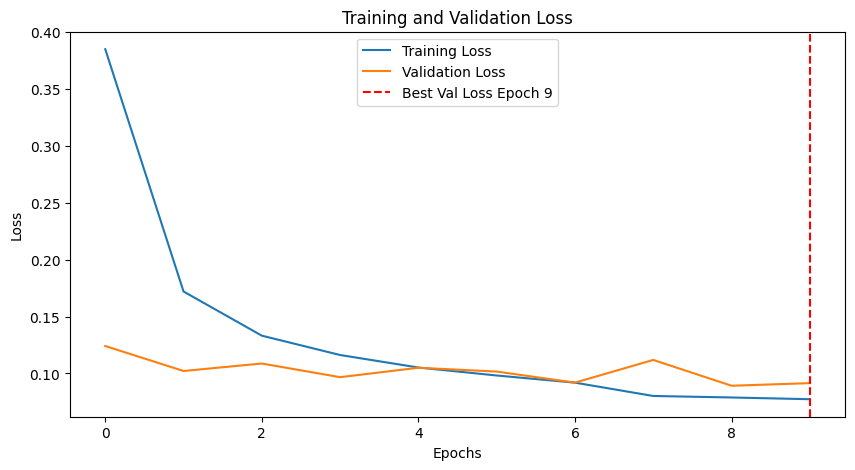

In [132]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

# Find the epoch with the best validation loss
best_epoch = np.argmin(val_losses) + 1 # Add 1 because epochs are 1-indexed

# Add a vertical red line at the epoch with the best validation loss
plt.axvline(x=best_epoch, color='red', linestyle='--', label=f'Best Val Loss Epoch {best_epoch}')
plt.legend()

plt.show()

### Load best version of model

In [133]:
# Define the path where the best model was saved
path = Path(os.getcwd())
model_save_path = path / 'best_new_lenet.pth'

# Instantiate a new model with the same architecture
# Make sure you use the same model class that was trained
loaded_model = NewModernLeNet5()

# Load the saved state dictionary into the new model instance
# Make sure the model is on the correct device (CPU or GPU)
device = "cuda" if torch.cuda.is_available() else "cpu"
loaded_model.load_state_dict(torch.load(model_save_path, map_location=device))

# Move the model to the device
loaded_model = loaded_model.to(device)

# Set the model to evaluation mode
loaded_model.eval()

print(f"Model loaded successfully from {model_save_path}")
print(f"Model is on device: {next(loaded_model.parameters()).device}")

Model loaded successfully from /home/linus/HPI/cv-seminar/best_new_lenet.pth
Model is on device: cuda:0


## 4.3 Apply Model

In [134]:
# This uses the torch_train_set which is derived from train_dataset
new_train_inference_loader = torch.utils.data.DataLoader(
    new_torch_train_set,
    batch_size=batch_size,
    shuffle=False,    # CRITICAL: Must be False for ordered predictions
    num_workers=num_workers,
    pin_memory=True
)

# Set the loaded model to evaluation mode
loaded_model.eval()

# Lists to store predictions and logits for the training set
train_predictions = []
train_all_logits = []

# Run inference on the training set using the NON-SHUFFLED loader
print("Applying LeNet model to the train_dataset (using non-shuffled loader)...")
with torch.inference_mode(): # Disable gradient calculation
    # Use the new train_inference_loader
    for images, _ in tqdm(new_train_inference_loader, desc="Processing train batches for inference"):
        images = images.to(device)

        # Forward pass to get logits
        logits = loaded_model(images)
        train_all_logits.append(logits.cpu().numpy()) # Store logits

        # Get predicted class indices
        _, predicted = torch.max(logits.data, 1)
        train_predictions.extend(predicted.cpu().numpy()) # Store predictions

# Concatenate logits from all batches
train_all_logits = np.concatenate(train_all_logits, axis=0)

print("Inference on train_dataset complete.")
print(f"Shape of collected train logits: {train_all_logits.shape}")
print(f"Number of collected train predictions: {len(train_predictions)}")

# Store the predictions and logits back into the FiftyOne dataset as Classification objects
print("Storing predictions and logits as FiftyOne Classifications for train_dataset...")
for i, sample in enumerate(tqdm(new_train_dataset, desc="Storing train classifications")):
    predicted_idx = train_predictions[i]
    predicted_label = new_classes[predicted_idx] # Assuming dataset_classes is consistent
    sample_logits = train_all_logits[i]
    confidences = Fun.softmax(torch.tensor(sample_logits), dim=0).numpy()
    predicted_confidence = float(confidences[predicted_idx])
    classification = fo.Classification(
        label=predicted_label,
        confidence=predicted_confidence,
        logits=sample_logits.tolist()
    )
    sample["lenet_classification"] = classification
    sample.save()

print("Predictions and logits stored successfully as FiftyOne Classifications for train_dataset.")

Applying LeNet model to the train_dataset (using non-shuffled loader)...


Processing train batches for inference: 100%|██████████| 797/797 [00:06<00:00, 127.24it/s]


Inference on train_dataset complete.
Shape of collected train logits: (51000, 11)
Number of collected train predictions: 51000
Storing predictions and logits as FiftyOne Classifications for train_dataset...


Storing train classifications: 100%|██████████| 51000/51000 [04:10<00:00, 203.31it/s]

Predictions and logits stored successfully as FiftyOne Classifications for train_dataset.


In [135]:
# do the same for the validation dataset
# This uses the torch_val_set which is derived from val_dataset
new_val_inference_loader = torch.utils.data.DataLoader(
    new_torch_val_set,
    batch_size=batch_size,
    shuffle=False,    # CRITICAL: Must be False for ordered predictions
    num_workers=num_workers,
    pin_memory=True
)

# Set the loaded model to evaluation mode
loaded_model.eval()

# Lists to store predictions and logits for the training set
val_predictions = []
val_all_logits = []

# Run inference on the training set using the NON-SHUFFLED loader
print("Applying LeNet model to the train_dataset (using non-shuffled loader)...")
with torch.inference_mode(): # Disable gradient calculation
    # Use the new val_inference_loader
    for images, _ in tqdm(new_val_inference_loader, desc="Processing val batches for inference"):
        images = images.to(device)

        # Forward pass to get logits
        logits = loaded_model(images)
        val_all_logits.append(logits.cpu().numpy()) # Store logits

        # Get predicted class indices
        _, predicted = torch.max(logits.data, 1)
        val_predictions.extend(predicted.cpu().numpy()) # Store predictions
# Concatenate logits from all batches
val_all_logits = np.concatenate(val_all_logits, axis=0)

print("Inference on train_dataset complete.")
print(f"Shape of collected val logits: {val_all_logits.shape}")
print(f"Number of collected val predictions: {len(val_predictions)}")

# Store the predictions and logits back into the FiftyOne dataset as Classification objects
print("Storing predictions and logits as FiftyOne Classifications for val_dataset...")
for i, sample in enumerate(tqdm(new_val_dataset, desc="Storing val classifications")):
    predicted_idx = val_predictions[i]
    predicted_label = new_classes[predicted_idx] # Assuming dataset_classes is consistent
    sample_logits = val_all_logits[i]
    confidences = Fun.softmax(torch.tensor(sample_logits), dim=0).numpy()
    predicted_confidence = float(confidences[predicted_idx])
    classification = fo.Classification(
        label=predicted_label,
        confidence=predicted_confidence,
        logits=sample_logits.tolist()
    )
    sample["lenet_classification"] = classification
    sample.save()

print("Predictions and logits stored successfully as FiftyOne Classifications for val_dataset.")

Applying LeNet model to the train_dataset (using non-shuffled loader)...


Processing val batches for inference: 100%|██████████| 141/141 [00:03<00:00, 44.03it/s] 


Inference on train_dataset complete.
Shape of collected val logits: (9000, 11)
Number of collected val predictions: 9000
Storing predictions and logits as FiftyOne Classifications for val_dataset...


Storing val classifications: 100%|██████████| 9000/9000 [00:39<00:00, 230.39it/s]

Predictions and logits stored successfully as FiftyOne Classifications for val_dataset.


In [136]:
new_lenet_train_evaluation_results = new_train_dataset.evaluate_classifications(
    "lenet_classification",
    gt_field="ground_truth",
    eval_key="lenet_eval"
)

In [137]:
new_lenet_val_evaluation_results = new_val_dataset.evaluate_classifications(
    "lenet_classification",
    gt_field="ground_truth",
    eval_key="lenet_eval"
)

In [ ]:
new_val_dataset.name = "new-mnist-val"
new_train_dataset.name = "new-mnist-train"

In [147]:
# add train_val and test datasets together and exclude difficult samples
cleaned_dataset = train_val_dataset.clone()
cleaned_dataset.merge_samples(test_dataset)
cleaned_dataset = cleaned_dataset.exclude(cleaned_dataset.match(
    fo.ViewField("filepath").is_in(combined_difficult_samples))).clone()

In [148]:
len(cleaned_dataset)

69807

In [175]:
# publish to Hugging Face Hub
hf_dataset_name = "mnist-cleaned-full"
print(f"\nPushing dataset to Hugging Face Hub: {hf_dataset_name}")
fouh.push_to_hub(cleaned_dataset, hf_dataset_name, exist_ok=True)
print(f"Dataset '{hf_dataset_name}' successfully pushed to Hugging Face Hub!")


Pushing dataset to Hugging Face Hub: mnist-cleaned-full
Dataset has more than 10,000 samples. Chunking by default to avoid exceeding the maximum number of files in a directory on Hugging Face Hub. Setting chunk_size to 1000.
Directory '/tmp/tmpmlbaxwxv' already exists; export will be merged with existing files
Exporting samples...
 100% |████████████████| 69807/69807 [13.5s elapsed, 0s remaining, 6.2K docs/s]      


No files have been modified since last commit. Skipping to prevent empty commit.
No files have been modified since last commit. Skipping to prevent empty commit.
No files have been modified since last commit. Skipping to prevent empty commit.
Uploading media files in 70 batches of size 1000:   0%|          | 0/70 [00:00<?, ?it/s]It seems you are trying to upload a large folder at once. This might take some time and then fail if the folder is too large. For such cases, it is recommended to upload in smaller batches or to use `HfApi().upload_large_folder(...)`/`hf upload-large-folder` instead. For more details, check out https://huggingface.co/docs/huggingface_hub/main/en/guides/upload#upload-a-large-folder.
No files have been modified since last commit. Skipping to prevent empty commit.
Uploading media files in 70 batches of size 1000:   1%|▏         | 1/70 [00:03<04:04,  3.54s/it]It seems you are trying to upload a large folder at once. This might take some time and then fail if the fo

Dataset 'mnist-cleaned-full' successfully pushed to Hugging Face Hub!


find the dataset [here](https://huggingface.co/datasets/Linus-L/mnist-cleaned-full)